In the realm of time series forecasting and analysis, one of the more complex tasks is identifying the model that is optimally suited for a specific group of series. Quite often, this selection process leans heavily on intuition, which may not necessarily align with the empirical reality of our dataset.



In [1]:
import pandas as pd

In [2]:
# Load the training target dataset from the provided URL
Y_df = pd.read_parquet("https://m5-benchmarks.s3.amazonaws.com/data/train/target.parquet")

# Rename columns to match the Nixtlaverse's expectations
# The 'item_id' becomes 'unique_id' representing the unique identifier of the time series
# The 'timestamp' becomes 'ds' representing the time stamp of the data points
# The 'demand' becomes 'y' representing the target variable we want to forecast
Y_df = Y_df.rename(columns={"item_id": "unique_id", "timestamp": "ds", "demand": "y"})

# Convert the 'ds' column to datetime format to ensure proper handling of date-related operations in subsequent steps
Y_df["ds"] = pd.to_datetime(Y_df["ds"])

In [3]:
# For simplicity sake we will keep just one category
Y_df = Y_df.query('unique_id.str.startswith("FOODS_3")').reset_index(drop=True)

Y_df["unique_id"] = Y_df["unique_id"].astype(str)

In [4]:
from statsforecast import StatsForecast
from tqdm.autonotebook import tqdm

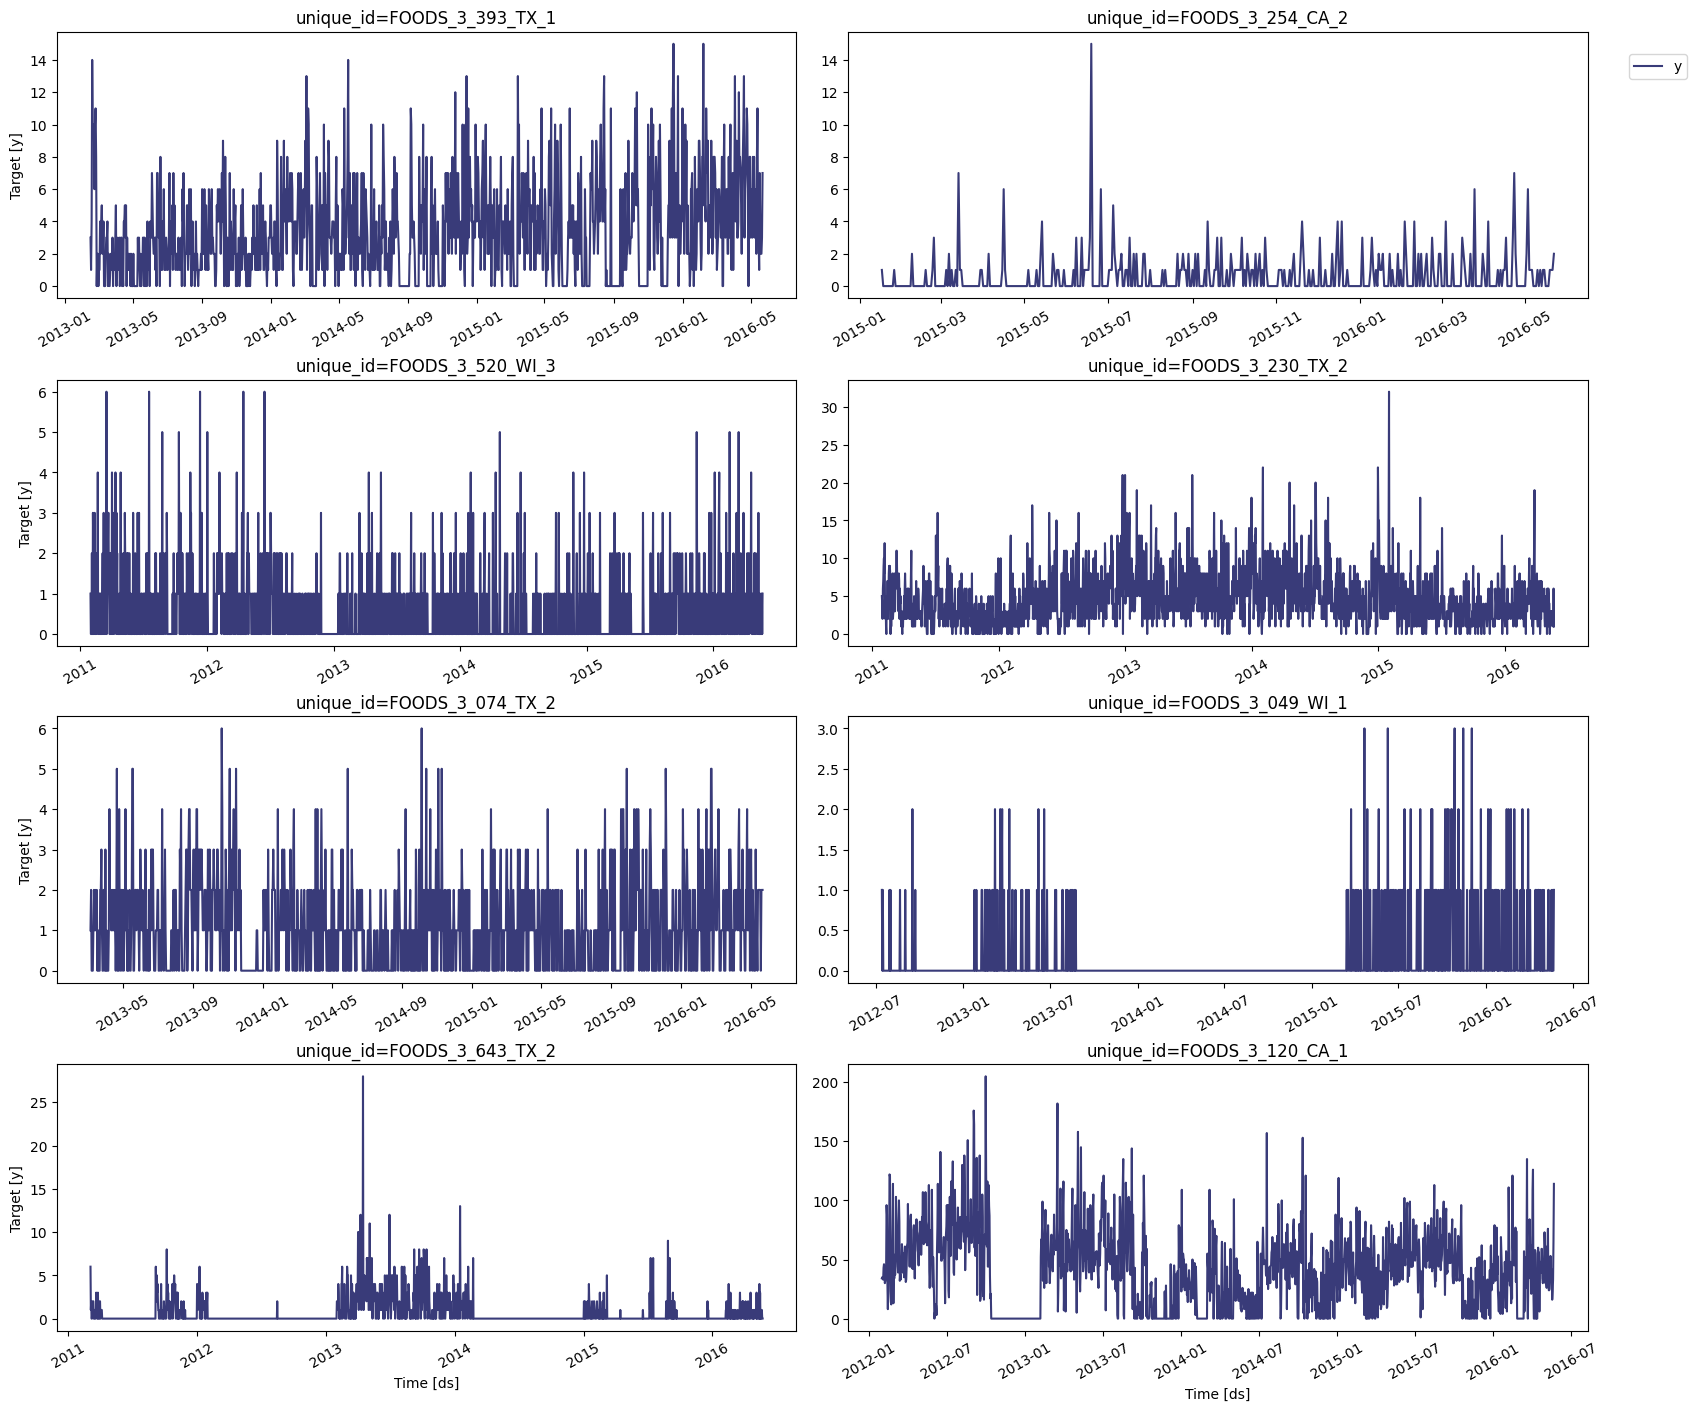

In [5]:
# Feature: plot random series for EDA
StatsForecast.plot(Y_df)

### StatsForecast

In [6]:
# Import necessary models from the statsforecast library
from statsforecast.models import (  # SeasonalNaive: A model that uses the previous season's data as the forecast; Naive: A simple model that uses the last observed value as the forecast; HistoricAverage: This model uses the average of all historical data as the forecast; CrostonOptimized: A model specifically designed for intermittent demand forecasting; ADIDA: Adaptive combination of Intermittent Demand Approaches, a model designed for intermittent demand; IMAPA: Intermittent Multiplicative AutoRegressive Average, a model for intermittent series that incorporates autocorrelation; AutoETS: Automated Exponential Smoothing model that automatically selects the best Exponential Smoothing model based on AIC
    ADIDA,
    IMAPA,
    AutoETS,
    CrostonOptimized,
    HistoricAverage,
    Naive,
    SeasonalNaive,
)

In [7]:
horizon = 28
models = [
    SeasonalNaive(season_length=7),
    Naive(),
    HistoricAverage(),
    CrostonOptimized(),
    ADIDA(),
    IMAPA(),
    AutoETS(season_length=7),
]

In [8]:
# Instantiate the StatsForecast class
sf = StatsForecast(
    models=models,  # A list of models to be used for forecasting
    freq="D",  # The frequency of the time series data (in this case, 'D' stands for daily frequency)
    n_jobs=-1,  # The number of CPU cores to use for parallel execution (-1 means use all available cores)
)

In [9]:
from time import time

# Get the current time before forecasting starts, this will be used to measure the execution time
init = time()

# Call the forecast method of the StatsForecast instance to predict the next 28 days (h=28)
# Level is set to [90], which means that it will compute the 90% prediction interval
fcst_df = sf.forecast(df=Y_df, h=28)

# Get the current time after the forecasting ends
end = time()

# Calculate and print the total time taken for the forecasting in minutes
print(f"Forecast Minutes: {(end - init) / 60}")

Forecast Minutes: 1.7967799107233684


In [10]:
fcst_df.head()

,unique_id,ds,SeasonalNaive,Naive,HistoricAverage,CrostonOptimized,ADIDA,IMAPA,AutoETS
0,FOODS_3_001_CA_1,2016-05-23,1.0,2.0,0.448738,0.345192,0.345477,0.347249,0.381414
1,FOODS_3_001_CA_1,2016-05-24,0.0,2.0,0.448738,0.345192,0.345477,0.347249,0.286933
2,FOODS_3_001_CA_1,2016-05-25,0.0,2.0,0.448738,0.345192,0.345477,0.347249,0.334987
3,FOODS_3_001_CA_1,2016-05-26,1.0,2.0,0.448738,0.345192,0.345477,0.347249,0.186851
4,FOODS_3_001_CA_1,2016-05-27,0.0,2.0,0.448738,0.345192,0.345477,0.347249,0.308112


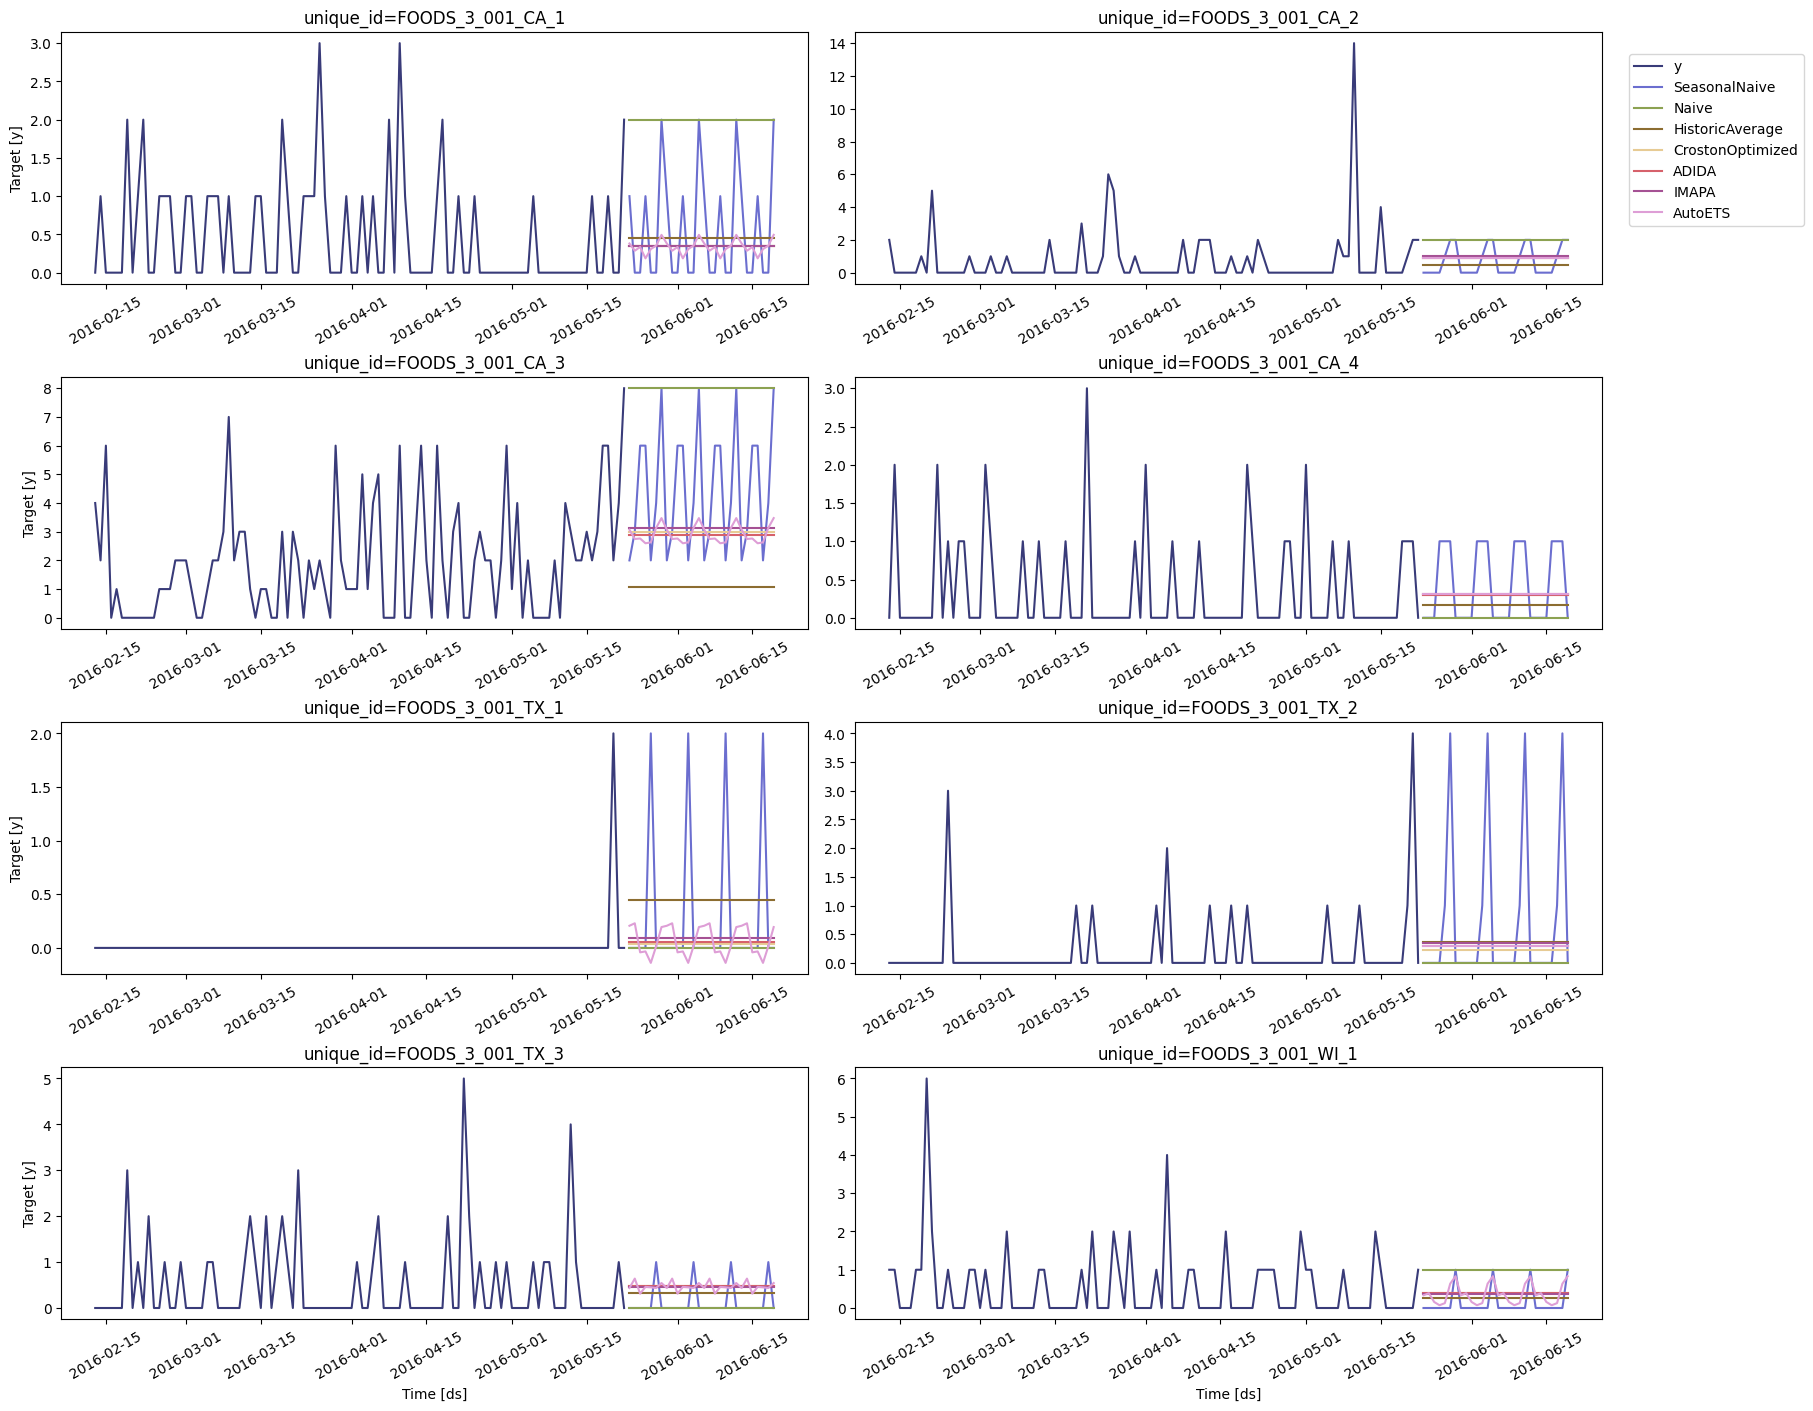

In [11]:
sf.plot(Y_df, fcst_df, max_insample_length=100, unique_ids=Y_df.unique_id.unique()[:8])

### MLForecast

In [12]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.utils import PredictionIntervals
from window_ops.expanding import expanding_mean

In [13]:
# Import the necessary models from various libraries

# LGBMRegressor: A gradient boosting framework that uses tree-based learning algorithms from the LightGBM library
from lightgbm import LGBMRegressor

# LinearRegression: A simple linear regression model from the scikit-learn library
from sklearn.linear_model import LinearRegression

# XGBRegressor: A gradient boosting regressor model from the XGBoost library
from xgboost import XGBRegressor

In [14]:
# Instantiate the MLForecast object
mlf = MLForecast(
    models=[
        LGBMRegressor(),
        XGBRegressor(),
        LinearRegression(),
    ],  # List of models for forecasting: LightGBM, XGBoost and Linear Regression
    freq="D",  # Frequency of the data - 'D' for daily frequency
    lags=list(range(1, 7)),  # Specific lags to use as regressors: 1 to 6 days
    lag_transforms={
        1: [expanding_mean],  # Apply expanding mean transformation to the lag of 1 day
    },
    date_features=[
        "year",
        "month",
        "day",
        "dayofweek",
        "quarter",
        "week",
    ],  # Date features to use as regressors
)

In [15]:
# Start the timer to calculate the time taken for fitting the models
init = time()

# Fit the MLForecast models to the data, with prediction intervals set using a window size of 28 days
mlf.fit(Y_df, prediction_intervals=PredictionIntervals(h=28))

# Calculate the end time after fitting the models
end = time()

# Print the time taken to fit the MLForecast models, in minutes
print(f"MLForecast Minutes: {(end - init) / 60}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1157
[LightGBM] [Info] Number of data points in the train set: 12045188, number of used features: 13
[LightGBM] [Info] Start training from score 2.629274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1153
[LightGBM] [Info] Number of data points in the train set: 12506068, number of used features: 13
[LightGBM] [Info] Start training from score 2.621166
MLForecast Minutes: 1.7426987449328104


In [16]:
fcst_mlf_df = mlf.predict(28, level=[90])

In [17]:
fcst_mlf_df.head()

,unique_id,ds,LGBMRegressor,XGBRegressor,LinearRegression,LGBMRegressor-lo-90,LGBMRegressor-hi-90,XGBRegressor-lo-90,XGBRegressor-hi-90,LinearRegression-lo-90,LinearRegression-hi-90
0,FOODS_3_001_CA_1,2016-05-23,0.549520,0.560123,0.359638,-0.213915,1.312955,-0.055540,1.175786,0.029998,0.689278
1,FOODS_3_001_CA_1,2016-05-24,0.553196,0.369337,0.100361,-0.251383,1.357775,-0.167594,0.906268,-0.216199,0.416921
2,FOODS_3_001_CA_1,2016-05-25,0.599668,0.374338,0.175840,-0.203974,1.403309,-0.267584,1.016260,-0.150597,0.502278
3,FOODS_3_001_CA_1,2016-05-26,0.638097,0.327176,0.156460,0.118688,1.157506,-0.071907,0.726258,-0.273844,0.586763
4,FOODS_3_001_CA_1,2016-05-27,0.763305,0.331631,0.328194,-0.313091,1.839701,-0.264054,0.927317,-0.657093,1.313480


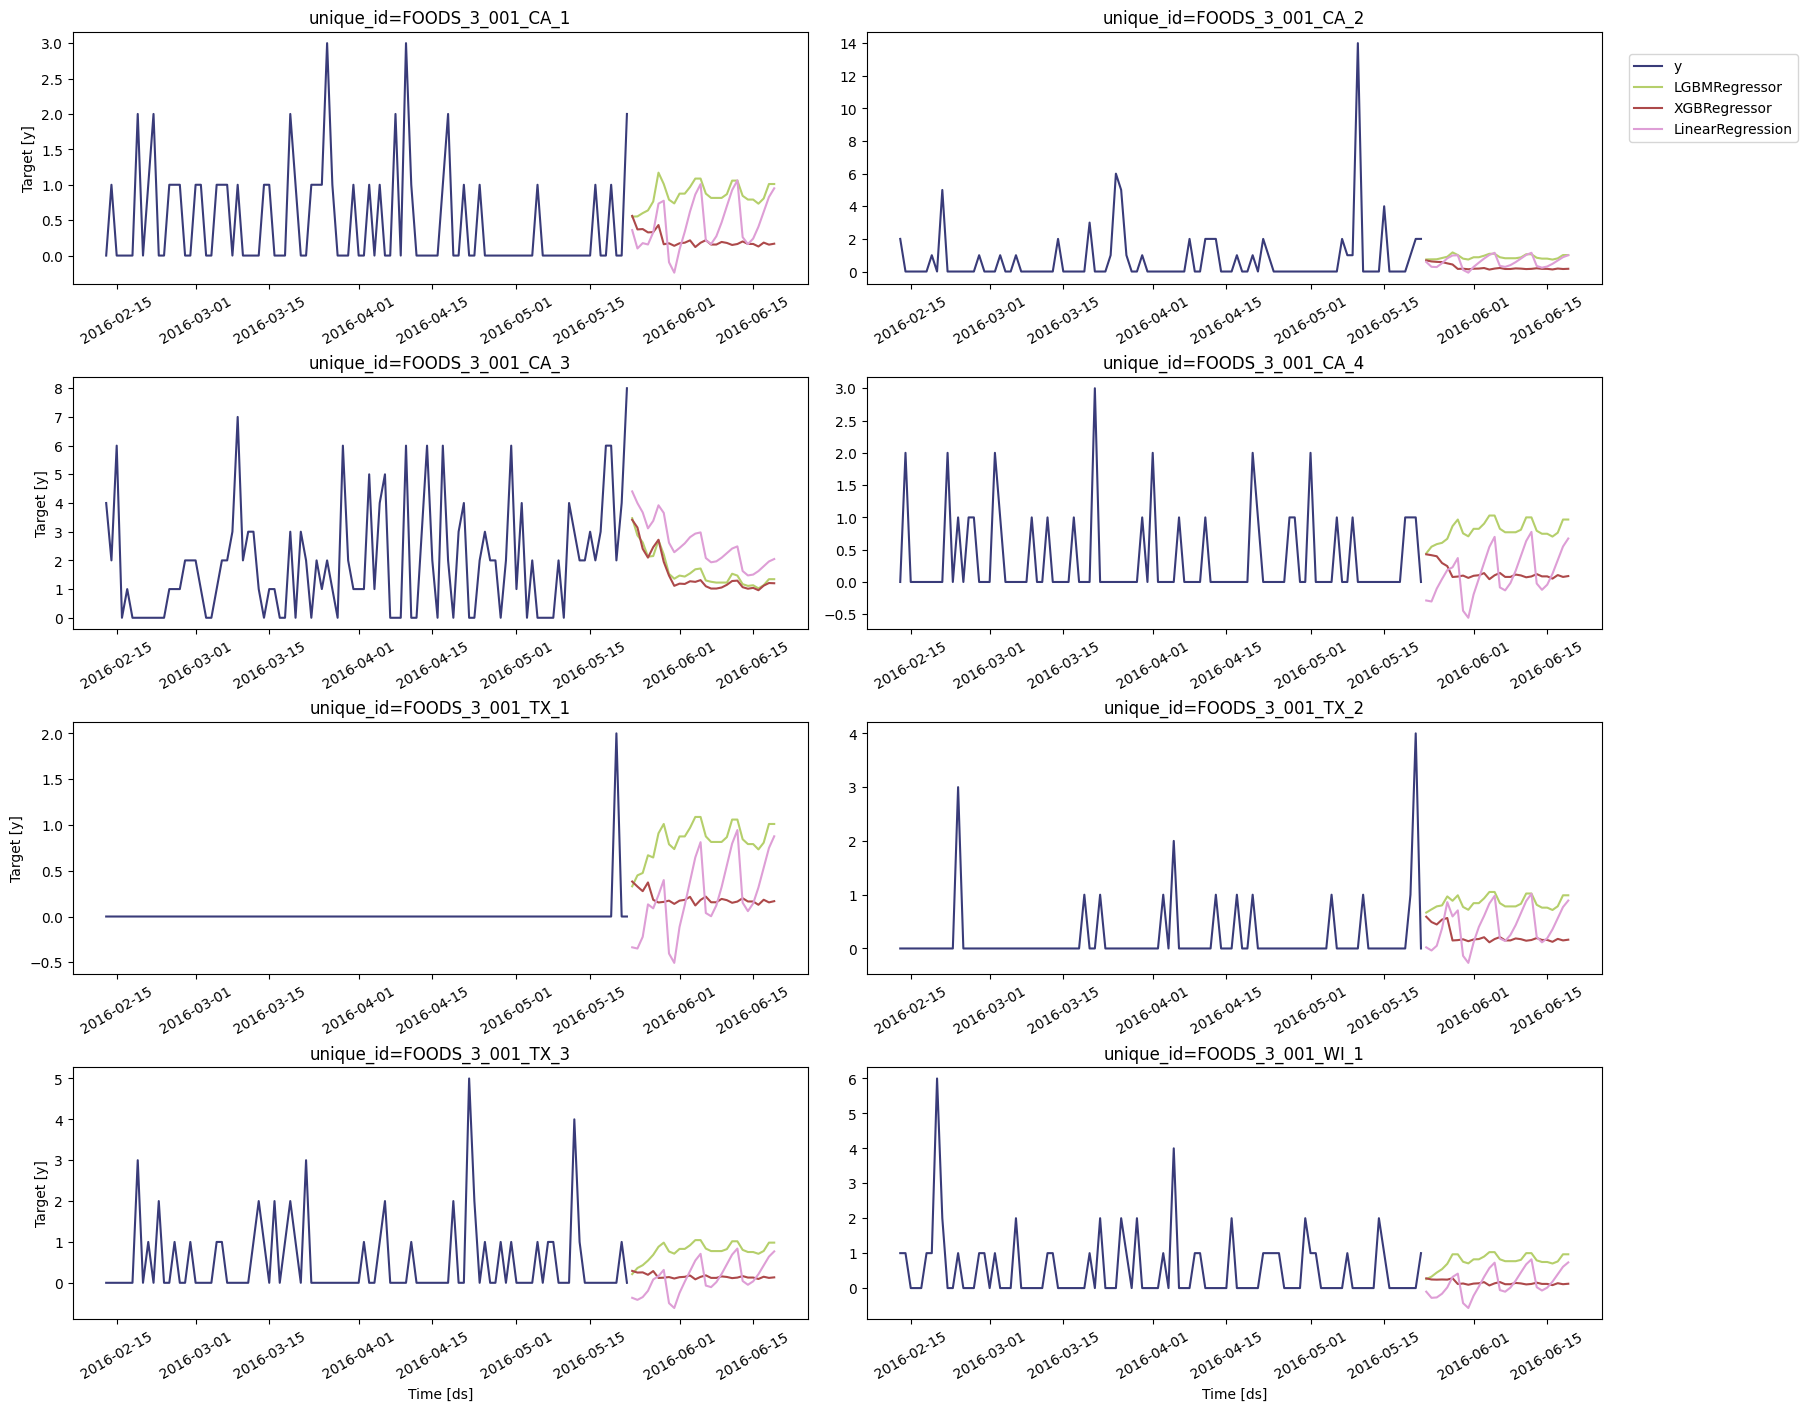

In [18]:
sf.plot(Y_df, fcst_mlf_df, max_insample_length=100, unique_ids=Y_df.unique_id.unique()[:8])

## NeuralForecast
